In [87]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter
import h5py
import os
import pickle

In [88]:
grid_size = (100, 100) 
num_cells = 5
num_genes = 30
cell_types = 20
umi_range = (20, 80)

In [89]:
cell_type_profiles = np.random.dirichlet(np.ones(num_genes), cell_types)

In [28]:
# genes_per_subset = 1

# cell_type_profiles = np.zeros((cell_types, num_genes))

# gene_indices = np.arange(num_genes)
# np.random.shuffle(gene_indices)

# for i in range(cell_types):
#     subset_indices = gene_indices[i * genes_per_subset:(i + 1) * genes_per_subset]
    
#     cell_type_profiles[i, subset_indices] = np.random.dirichlet(np.ones(genes_per_subset), 1)


In [90]:
cell_type_profiles.shape

(20, 30)

In [91]:
cell_type_profiles[1]

array([0.00172653, 0.00160621, 0.14240782, 0.02432277, 0.07257849,
       0.05221128, 0.01006503, 0.02816973, 0.06974825, 0.00268775,
       0.00775529, 0.00023776, 0.11548783, 0.00628669, 0.01086815,
       0.08742896, 0.00944416, 0.04163007, 0.1094141 , 0.00040352,
       0.00579019, 0.00185531, 0.00453297, 0.05317299, 0.02359878,
       0.02284167, 0.07402971, 0.01005131, 0.00064496, 0.00900172])

In [92]:
def generate_single_cell():
    cell_type_idx = np.random.choice(cell_types)
    umi_count = np.random.randint(umi_range[0], umi_range[1])
    expression_vector = np.random.poisson(umi_count * cell_type_profiles[cell_type_idx])
    
    return (expression_vector, cell_type_idx, umi_count)

In [93]:
len(generate_single_cell()[0])

30

In [94]:
def create_cell_mask(shape_type='oval', size=(15, 10)):
    mask = np.zeros(size)
    rr, cc = np.ogrid[:size[0], :size[1]]
    if shape_type == 'oval':
        mask[(rr - size[0]//2)**2 / size[0]**2 + (cc - size[1]//2)**2 / size[1]**2 < 0.25] = 1
    elif shape_type == 'circle':
        mask[(rr - size[0]//2)**2 + (cc - size[1]//2)**2 < (size[0]//2)**2] = 1
    elif shape_type == 'rectangle':
        mask[:,:] = 1
    return mask

In [95]:
def is_overlapping(grid, mask, pos):
    x, y = pos
    if x + mask.shape[0] > grid.shape[0] or y + mask.shape[1] > grid.shape[1]:
        return True
    return np.any(grid[x:x+mask.shape[0], y:y+mask.shape[1]] * mask)

In [97]:
def place_cells(grid, num_cells):
    cell_positions = []
    for _ in range(num_cells):

        shape = random.choice(['oval', 'circle'])#, 'rectangle'])
        size = (random.randint(10, 20), random.randint(10, 20))
        mask = create_cell_mask(shape, size)
        
        gene_counts, cell_type, num_transcripts = generate_single_cell()
        gene_distribution = []
        for gene_idx, count in enumerate(gene_counts):
            gene_distribution.extend([gene_idx] * count)  # Add gene indices based on count
        print(max(gene_distribution))
        for _ in range(1000):
            x, y = np.random.randint(0, grid_size[0] - size[0]), np.random.randint(0, grid_size[1] - size[1])
            if not is_overlapping(grid, mask, (x, y)):
                gene_index_grid = np.zeros_like(mask, dtype=int)
                mask_indices = np.argwhere(mask == 1)
                if len(gene_distribution) > len(mask_indices):
                    chosen_indices = np.random.choice(len(mask_indices), size=len(mask_indices), replace=True)
                    gene_distribution = gene_distribution[:len(mask_indices)]  
                else:
                    chosen_indices = np.random.choice(len(mask_indices), size=len(gene_distribution), replace=False)
                
                for i, (r, c) in enumerate(mask_indices[chosen_indices]):
                    gene_index_grid[r, c] = gene_distribution[i]
                
                grid[x:x+mask.shape[0], y:y+mask.shape[1]] += gene_index_grid
                cell_positions.append((x, y, size, shape, cell_type, num_transcripts))
                break
    return grid, cell_positions

In [128]:
grid = np.zeros(grid_size, dtype=int)
grid, cell_positions = place_cells(grid, num_cells)

29
29
29
29
23


In [130]:
cell_positions

[(76, 67, (11, 19), 'oval', 14, 59),
 (15, 28, (19, 17), 'circle', 2, 20),
 (13, 73, (12, 18), 'circle', 16, 63),
 (81, 5, (17, 18), 'oval', 15, 38),
 (52, 1, (17, 20), 'circle', 5, 30)]

In [100]:
len(cell_positions)

5

In [101]:
grid

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

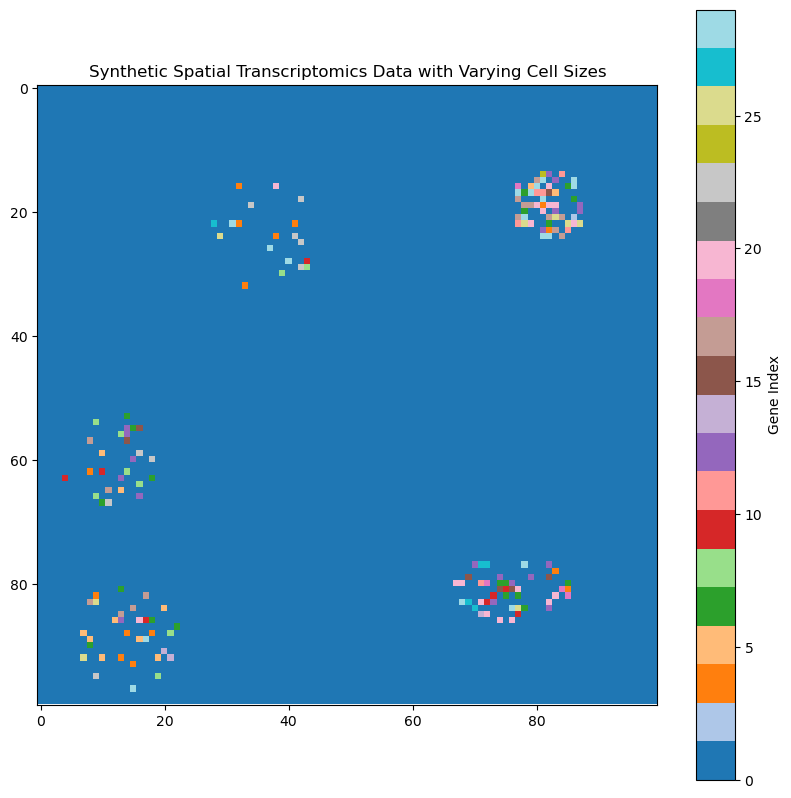

In [129]:
plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap='tab20', interpolation='nearest')
plt.colorbar(label='Gene Index')
plt.title("Synthetic Spatial Transcriptomics Data with Varying Cell Sizes")
plt.show()

In [131]:
def add_gaussian_noise(synthetic_grid, num_noise_points=100):
    x_noise = np.random.randint(0, grid_size[0], size=num_noise_points)
    y_noise = np.random.randint(0, grid_size[1], size=num_noise_points)
    random_genes = np.random.randint(0, num_genes, size=num_noise_points)

    # Add the Gaussian noise (random genes) to the grid at random positions
    for x, y, gene in zip(x_noise, y_noise, random_genes):
        if synthetic_grid[x, y] == 0:  # Only add noise where there's no existing transcript (optional)
            synthetic_grid[x, y] = gene
            
    return synthetic_grid

In [132]:
grid.shape

(100, 100)

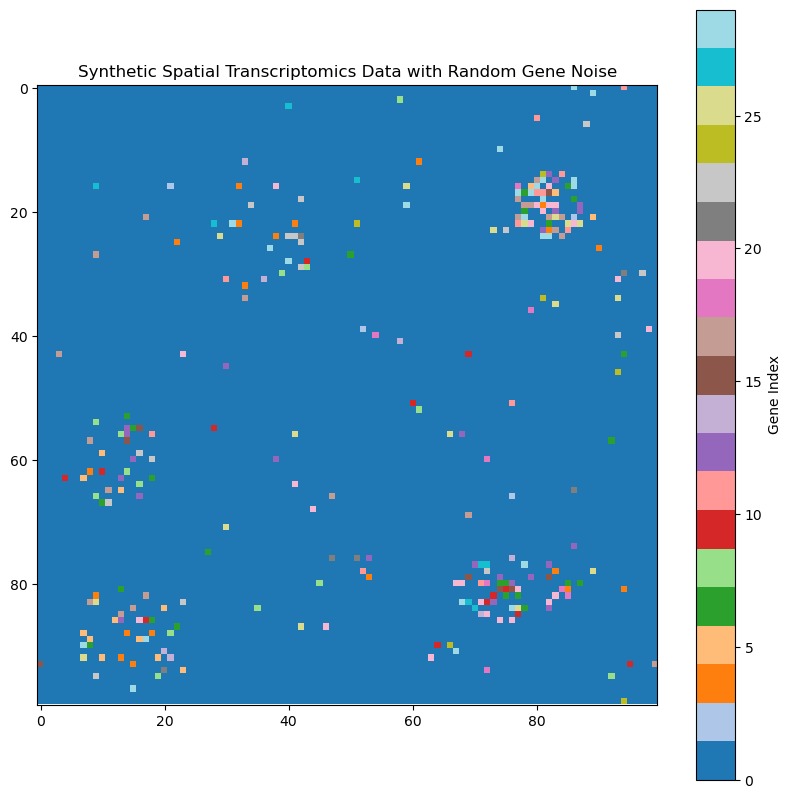

In [133]:

synthetic_grid = add_gaussian_noise(grid.copy())

# Plot the updated grid
plt.figure(figsize=(10, 10))
plt.imshow(synthetic_grid, cmap="tab20", interpolation='nearest')
plt.colorbar(label="Gene Index")
plt.title("Synthetic Spatial Transcriptomics Data with Random Gene Noise")
plt.show()

In [134]:
path = "/data/aram/Xenium/output-XETG00056__0004637__Region_1__20230718__204100/code/data/synthetic_data_2"
def make_patches(num_cells_in_grid, num_patches):
    for i in range(num_patches):
        grid = np.zeros(grid_size, dtype=int)
        grid, cell_positions = place_cells(grid, num_cells_in_grid)
        synthetic_grid = add_gaussian_noise(grid)
        
        y_coords, x_coords = np.nonzero(synthetic_grid)  # np.nonzero returns (y, x) coordinates
        gene_indices = synthetic_grid[y_coords, x_coords]  # Get the gene indices at those positions
        np.savez(path + '/data/gene_coordinates_'+str(i)+'.npz', x_coords=x_coords, y_coords=y_coords, gene_indices=gene_indices)
        with open(path+'/cell_positions/cell_'+str(i)+'.pkl', 'wb') as f:
            pickle.dump(cell_positions, f)

In [135]:
path = "/data/aram/Xenium/output-XETG00056__0004637__Region_1__20230718__204100/code/data/synthetic_data_2"

y_coords, x_coords = np.nonzero(grid)
gene_indices = grid[y_coords, x_coords]
np.savez(path + '/gene_coordinates_test_cells1'+'.npz', x_coords=x_coords, y_coords=y_coords, gene_indices=gene_indices)


In [136]:
with open("/data/aram/Xenium/output-XETG00056__0004637__Region_1__20230718__204100/code/data/synthetic_data_2/cell_type_profiles.pkl", 'wb') as f:
    pickle.dump(cell_type_profiles, f)